In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler


from sklearn.metrics import recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

import fairlearn.metrics as flm
from fairlearn.reductions import DemographicParity, ExponentiatedGradient
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import selection_rate
from fairlearn.postprocessing import ThresholdOptimizer

In [12]:
df_adult = (pd.read_csv("adult.csv").drop(columns=["fnlwgt", "relationship", "education"]))
print(f"The dataset contains {df_adult.shape[0]} data points and {df_adult.shape[1]} features.")
df_adult.head()

The dataset contains 32561 data points and 12 features.


,age,workclass,education.num,marital.status,occupation,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,9,Widowed,?,White,Female,0,4356,40,United-States,<=50K
1,82,Private,9,Widowed,Exec-managerial,White,Female,0,4356,18,United-States,<=50K
2,66,?,10,Widowed,?,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,4,Divorced,Machine-op-inspct,White,Female,0,3900,40,United-States,<=50K
4,41,Private,10,Separated,Prof-specialty,White,Female,0,3900,40,United-States,<=50K


<h2>Data Preprocessing<h2>

In [13]:
# Analyze which features has missing value (?)
missing_values = df_adult.isin(["?"]).sum()
print(f"Missing values in the dataset: \n{missing_values}")

print("\n")

# Print rows with missing values
print("Rows with missing values: ")
print(df_adult[(df_adult == "?").any(axis=1)])


Missing values in the dataset: 
age                  0
workclass         1836
education.num        0
marital.status       0
occupation        1843
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64


Rows with missing values: 
       age workclass  education.num      marital.status         occupation  \
0       90         ?              9             Widowed                  ?   
2       66         ?             10             Widowed                  ?   
9       41   Private             10       Never-married       Craft-repair   
14      51         ?             16       Never-married                  ?   
18      22   Private             12       Never-married  Handlers-cleaners   
...    ...       ...            ...                 ...                ...   
32533   35         ?             13  Married-civ-spouse                  ?   
32534   30         ?      

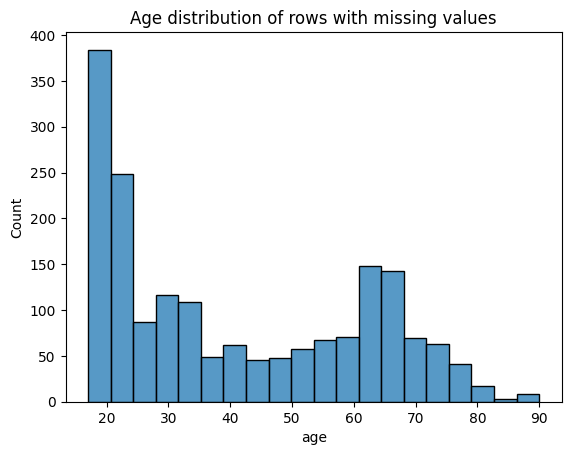

In [14]:
# Analyze age distribution of only rows with ? in workclass and occupation with histogramm
df_adult["age"] = pd.to_numeric(df_adult["age"])
df_adult["workclass"] = df_adult["workclass"].replace("?", np.nan)
df_adult["occupation"] = df_adult["occupation"].replace("?", np.nan)
df_adult_missing = df_adult[(df_adult["workclass"].isna()) & (df_adult["occupation"].isna())]
sns.histplot(data=df_adult_missing, x="age", bins=20)
plt.title("Age distribution of rows with missing values")
plt.show()


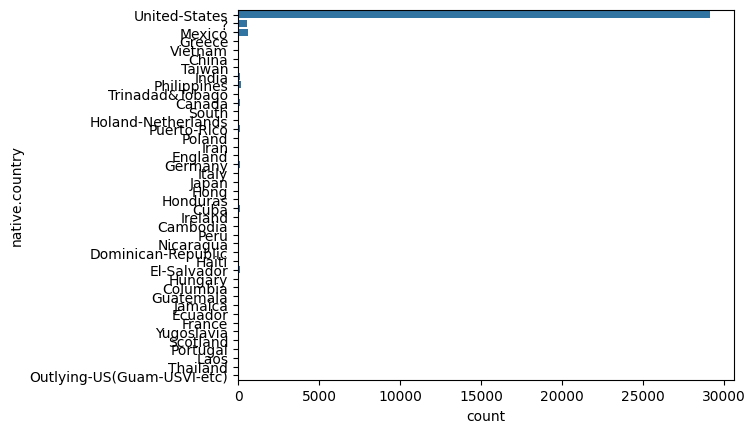

In [15]:
# Replace NaNs in workclass with "Private" and in occupation with "Unknown"
df_adult["workclass"] = df_adult["workclass"].replace(np.nan, "Private")
df_adult["occupation"] = df_adult["occupation"].replace(np.nan, "Unknown")

# Show distribution of native country
sns.countplot(data=df_adult, y="native.country")

# Replace missing values in native country with "United-States"
df_adult["native.country"] = df_adult["native.country"].replace("?", "United-States")




In [16]:
# Get description of dataset
print(df_adult.describe())

# Replace values with 99999 in capital gain and hours per week with mean
df_adult["capital.gain"] = df_adult["capital.gain"].replace(99999, df_adult["capital.gain"].mean())
df_adult["hours.per.week"] = df_adult["hours.per.week"].replace(99, df_adult["hours.per.week"].mean())

# Get description of dataset
print(df_adult.describe())

                age  education.num  capital.gain  capital.loss  hours.per.week
count  32561.000000   32561.000000  32561.000000  32561.000000    32561.000000
mean      38.581647      10.080679   1077.648844     87.303830       40.437456
std       13.640433       2.572720   7385.292085    402.960219       12.347429
min       17.000000       1.000000      0.000000      0.000000        1.000000
25%       28.000000       9.000000      0.000000      0.000000       40.000000
50%       37.000000      10.000000      0.000000      0.000000       40.000000
75%       48.000000      12.000000      0.000000      0.000000       45.000000
max       90.000000      16.000000  99999.000000   4356.000000       99.000000
                age  education.num  capital.gain  capital.loss  hours.per.week
count  32561.000000   32561.000000  32561.000000  32561.000000    32561.000000
mean      38.581647      10.080679    594.601799     87.303830       40.284579
std       13.640433       2.572720   2554.224665    

<h2>Data Analysis</h2>

<h2> Data Preparation</h2>

In [19]:
# DataFrame filtered by numerical features
numerical_features = ["age", "capital.gain", "capital.loss", "hours.per.week"]
df_numerical = df_adult[numerical_features]

# MinMaxScaler
scaler = StandardScaler()
numerical_scaled = scaler.fit_transform(df_numerical)

# Create DataFrame with scaled numerical features
df_numerical_scaled = pd.DataFrame(numerical_scaled, columns=numerical_features)

# DataFrame filtered by categorical features
catergorical_features = ["workclass", "education.num", "marital.status", "occupation", "race", "sex", "native.country"]
df_categorical = df_adult[catergorical_features]

# Binary encoding for female (0) and male (1)
sex_mapping = {"Female": 0, "Male": 1}
df_categorical.loc[:, "sex"] = df_categorical["sex"].replace(sex_mapping)

# For simplicity we differentiate between white (0) and "others" (1)
race_mapping = {"White": 0, "Black": 1, "Asian-Pac-Islander": 1, "Amer-Indian-Eskimo": 1, "Other": 1}
df_categorical.loc[:, "race"] = df_categorical["race"].replace(race_mapping)

# One-hot encoding for categorical features
df_categorical = pd.get_dummies(df_categorical, columns=["workclass", "marital.status", "occupation", "native.country"])

# Concatenate numerical and categorical features
df_adult_scaled = pd.concat([df_numerical_scaled, df_categorical], axis=1)

# Target variable
target = df_adult["income"]

# Target variable encoding
target_mapping = {"<=50K": 0, ">50K": 1}
df_target = target.replace(target_mapping)

# Concatenate features and target variable
df_adult_scaled = pd.concat([df_adult_scaled, df_target], axis=1)

df_adult_scaled.head()


C:\Users\manue\AppData\Local\Temp\ipykernel_26224\3278151919.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_categorical.loc[:, "sex"] = df_categorical["sex"].replace(sex_mapping)
C:\Users\manue\AppData\Local\Temp\ipykernel_26224\3278151919.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_categorical.loc[:, "race"] = df_categorical["race"].replace(race_mapping)
C:\Users\manue\AppData\Local\Temp\ipykernel_26224\3278151919.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a f

,age,capital.gain,capital.loss,hours.per.week,education.num,race,sex,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native.country_Puerto-Rico,native.country_Scotland,native.country_South,native.country_Taiwan,native.country_Thailand,native.country_Trinadad&Tobago,native.country_United-States,native.country_Vietnam,native.country_Yugoslavia,income
0,3.769612,-0.232795,10.593507,-0.023758,9,0,0,False,False,False,...,False,False,False,False,False,False,True,False,False,0
1,3.183112,-0.232795,10.593507,-1.860423,9,0,0,False,False,False,...,False,False,False,False,False,False,True,False,False,0
2,2.010110,-0.232795,10.593507,-0.023758,10,1,0,False,False,False,...,False,False,False,False,False,False,True,False,False,0
3,1.130359,-0.232795,9.461864,-0.023758,4,0,0,False,False,False,...,False,False,False,False,False,False,True,False,False,0
4,0.177296,-0.232795,9.461864,-0.023758,10,0,0,False,False,False,...,False,False,False,False,False,False,True,False,False,0
